# Implementation of a simple decision tree

[Kevin McGuinness](http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, Dublin City University

---

In this notebook we implement a simple decision tree. In fact, this is really a regression tree, since we use sum of squared error as an impurity measure rather than something like Entropy or the Gini index. Nevertheless, it can be used as a decision tree and gives reasonable results. It is left as an exercise to modify the tree to use the Gini index instead of squared error to measure node impurity, which would be more appropriate for classification.

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Define some utility functions

These are some auxillary functions that will be used in the next few colab notebooks.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib as mpl


mpl.rcParams['figure.figsize'] = (8,6)


def load_dataset(fn):
    data = np.load(fn)
    return data['X'], data['y']


def plot_dataset(X, y, save=None, pos=1, neg=-1):
    figure(figsize=(8,6))
    positives = X[y==pos]
    negatives = X[y==neg]
    scatter(positives[:,0], positives[:,1], s=100, c='b', marker='*', label='positives')
    scatter(negatives[:,0], negatives[:,1], s=60, c='r', marker='^', label='negatives')
    legend()
    if save:
        savefig(save)
    show()


def scatter_dataset(X, y, palette='Set2'):
    classes = np.unique(y)
    colors = sns.color_palette(palette, len(classes))
    for cls, color in zip(classes, colors):
        values = X[y==cls]
        scatter(values[:, 0], values[:, 1], s=60, c=color, label=cls)
    legend()


def generate_meshgrid_for_data(X, y):

    # Find span of data
    x0_min, x1_min = np.min(X, axis=0)
    x0_max, x1_max = np.max(X, axis=0)
    x0_range = x0_max - x0_min
    x1_range = x1_max - x1_min

    # Add small buffer around data
    x0_min = x0_min - 0.1 * x0_range
    x0_max = x0_max + 0.1 * x0_range
    x1_min = x1_min - 0.1 * x1_range
    x1_max = x1_max + 0.1 * x1_range

    # Generate linearly spaced points
    x0 = np.linspace(x0_min, x0_max, 100)
    x1 = np.linspace(x1_min, x1_max, 100)

    # Generate meshgrid
    X0, X1 = np.meshgrid(x0, x1)
    return X0, X1


def fill_decision_function(df, X, y, save=None, levels=(-1,0,1)):

    # Generate meshgrid
    X0, X1 = generate_meshgrid_for_data(X, y)

    # Evaluate decision function for all points on the grid
    Y = df(np.c_[X0.ravel(), X1.ravel()]).reshape(X0.shape)

    # Plot the decision function
    figure(figsize=(8,6))
    contourf(X0, X1, Y, cmap=cm.Blues)
    scatter_dataset(X, y)
    if save:
        savefig(save)
    show()


def plot_decision_function(df, X, y, save=None, levels=(-1,0,1)):

    # Generate meshgrid
    X0, X1 = generate_meshgrid_for_data(X, y)

    # Evaluate decision function for all points on the grid
    Y = df(np.c_[X0.ravel(), X1.ravel()]).reshape(X0.shape)

    # Plot the decision function
    figure(figsize=(8,6))
    contour(X0, X1, Y, levels=levels,
            linestyles=['dashed', 'solid', 'dashed'],
            linewidths=1,
            colors='k')

    scatter_dataset(X, y)
    if save:
        savefig(save)
    show()


## Generate some data


In [ ]:
from sklearn.datasets import make_blobs

In [ ]:
X, y = make_blobs(centers=2, random_state=3)

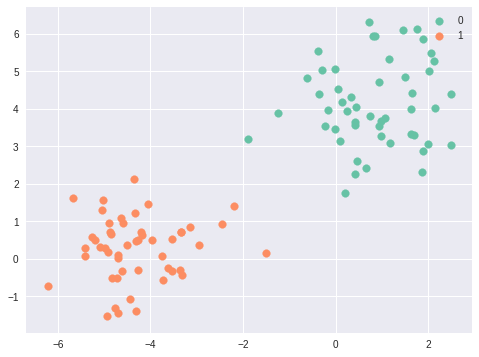

In [ ]:
scatter_dataset(X, y)

## Regression tree implementation

Here we implement a regression tree classifier. The tree is composed of ``Node`` objects, each of which may have a left and a right child node. The `make_tree` function constructs the tree and returns the root node. To construct the tree, we first place all of the data points in the root node, and then recursively split this node (`recursive_split_node`) until the max tree depth is reached. Splitting a node involves finding the split with minimum cost in all possible split dimensions and split points (`find_split`) and then dividing the data associated with the node using this split point (`split_dataset`). For simplicity, we use the sum of square errors from the centroid to measure node impurity.

The `predict` function recursively descends the tree based on the learned split rules and returns the mean class y value.

In [ ]:
def square_error(y, y_hat):
    return np.sum((y - y_hat)**2)
    

def split_cost(X, y, j, s):
    mask = X[:,j] <= s
    y1, y2 = y[mask], y[~mask]
    cost = 0
    if y1.size > 0:
        cost += square_error(y1, y1.mean())
    if y2.size > 0:
        cost += square_error(y2, y2.mean())
    return cost


def find_split(X, y):
    N, D = X.shape
    splits = [(j, s) for j in range(D) for s in X[:, j]]
    costs = [split_cost(X, y, j, s) for j, s in splits]
    best = np.argmin(costs)
    j, s = splits[best]
    return j, s, costs[best]

    
def plot_split(X, y, j, s):
    scatter_dataset(X, y)
    if j == 0:
        axvline(s)
    else:
        axhline(s)
            

def split_dataset(X, y, j, s):
    mask = X[:,j] <= s
    X1, X2 = X[mask], X[~mask]
    y1, y2 = y[mask], y[~mask]
    return X1, y1, X2, y2


class Node(object):
    def __init__(self, X, y, parent=None):
        self.X = X
        self.y = y
        self.impurity = square_error(y, y.mean())
        self.axis = None
        self.split = None
        self.left = None
        self.right = None
        self.parent = parent
        
    def __len__(self):
        return len(self.y)
    
    def predict_one(self, x):
        if self.split is None:
            return self.y.mean()
        if x[self.axis] <= self.split:
            return self.left.predict_one(x)
        else:
            return self.right.predict_one(x)
        
    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])
            
    def show(self, indent=0):
        space = indent * ' '
        print(space, 'feature =', self.axis, 'split =', 
              self.split, 'impurity =', self.impurity, 'size =', len(self))
        if self.left:
            self.left.show(indent+2)
        if self.right:
            self.right.show(indent+2)
        
        
def split_node(node):
    j, s, c = find_split(node.X, node.y)
    X1, y1, X2, y2 = split_dataset(node.X, node.y, j, s)
    if len(y1) > 0 and len(y2) > 0:
        node.axis = j
        node.split = s
        node.left = Node(X1, y1, parent=node)
        node.right = Node(X2, y2, parent=node)
    
def recursive_split_node(node, maxdepth=5, depth=0):
    if node is not None and depth < maxdepth:
        split_node(node)
        recursive_split_node(node.left, maxdepth, depth+1)
        recursive_split_node(node.right, maxdepth, depth+1)

def make_tree(X, y, maxdepth=5):
    root = Node(X, y)
    recursive_split_node(root, maxdepth)
    return root
    

## Fit the tree

In [ ]:
root = make_tree(X, y, maxdepth=3)

## Make predictions

In [ ]:
y_hat = root.predict(X)

## Plot the contours of the prediction function

The plot below shows a contour at 0.5 in the prediction function

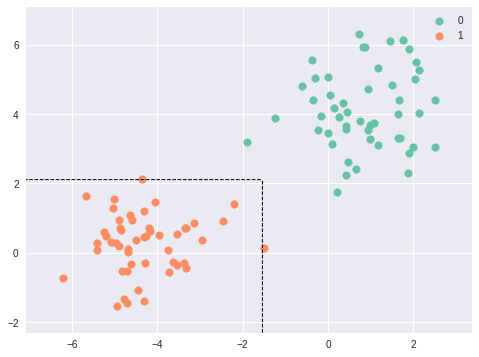

In [ ]:
plot_decision_function(root.predict, X, y, levels=(0, 0.5, 1))

## Show the tree structure

In [ ]:
root.show()

 feature = 0 split = -1.505792754087424 impurity = 25.0 size = 100
   feature = 1 split = 2.1258289132198263 impurity = 0.9803921568627452 size = 51
     feature = 0 split = -3.7559384718913287 impurity = 0.0 size = 50
       feature = None split = None impurity = 0.0 size = 37
       feature = None split = None impurity = 0.0 size = 13
     feature = None split = None impurity = 0.0 size = 1
   feature = 0 split = 1.8902437741020295 impurity = 0.0 size = 49
     feature = None split = None impurity = 0.0 size = 41
     feature = 0 split = 2.1399360104489773 impurity = 0.0 size = 8
       feature = None split = None impurity = 0.0 size = 6
       feature = None split = None impurity = 0.0 size = 2
